# 3s Dataset

## Dataset

In [1]:
import os
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
   
from utils.custom_datasets import *  
from utils.utils_functions import *

In [2]:
# Path to the csv file with the features
features_file = 'Data\\features_3_sec.csv'

### Custom Transformations for the dataset

Here we create some custom trasnformation for our dataset

In [3]:
# Here we compute the mean and the std of the features
data = pd.read_csv(features_file).drop(columns=['filename', 'length', 'label'])
mean = data.mean().to_numpy()
std = data.std().to_numpy()

custom_norm = CustomNormalize(mean=mean, std=std)

This trasformation encodes the labels in a one hot vector

In [4]:
labels = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz',
       'metal', 'pop', 'reggae', 'rock']
# Example usage of the transform
label_transform = LabelTransform(labels)

Here we instantiate the actual transformations

In [5]:
# Define a transform to convert the images to tensors and normalize them
target_transform = label_transform

transform_norm = custom_norm

Here we are creating the training and test dataset


In [6]:
# Create the dataset
gtzan_dataset = GTZANFeaturesDataset(features_file=features_file, transform=transform_norm, target_transform=target_transform)

# Split the dataset into training and test sets
training_data, test_data = torch.utils.data.random_split(gtzan_dataset, [8000, 1990])

# Create data loaders
batch_size = 100
shuffle = True
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=shuffle)         # Each element in the dataloader iterable will return a batch of 64 features and labels.
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=shuffle)                       # We need to use a batch size of 1 to test the model!!!

## Creating the Model

To build this model we used the official pytorch tutorials

In [7]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")


# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()

        # 4 Hidden layers
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(57, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 10),
        )

    # Here we define the behaviour of the forward pass
    def forward(self, x):                           
        logits = self.linear_relu_stack(x)               # 'logits' are the raw output of the final layer in the NN
        return logits                                    #  (the pre activations of the last layer before applying the last activation function (like softmax))


# Our model
model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=57, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=256, out_features=128, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=128, out_features=64, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.5, inplace=False)
    (12): Linear(in_features=64, out_features=10, bias=True)
  )
)


## Training the model

Here we choose the optimizers

In [8]:
loss_fn = nn.CrossEntropyLoss()              # This performs softmax internally
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

Training process

Epoch 1
loss: 1.370744
-------------------------------
Epoch 2
loss: 1.108813
-------------------------------
Epoch 3
loss: 0.905075
-------------------------------
Epoch 4
loss: 1.044616
-------------------------------
Epoch 5
loss: 0.594859
-------------------------------
Epoch 6
loss: 0.482576
-------------------------------
Epoch 7
loss: 0.659158
-------------------------------
Epoch 8
loss: 0.616205
-------------------------------
Epoch 9
loss: 0.652014
-------------------------------
Epoch 10
loss: 0.350793
-------------------------------
Epoch 11
loss: 0.438585
-------------------------------
Epoch 12
loss: 0.382318
-------------------------------
Epoch 13
loss: 0.314104
-------------------------------
Epoch 14
loss: 0.202284
-------------------------------
Epoch 15
loss: 0.341799
-------------------------------
Epoch 16
loss: 0.276389
-------------------------------
Epoch 17
loss: 0.233624
-------------------------------
Epoch 18
loss: 0.269338
-------------------------------
E

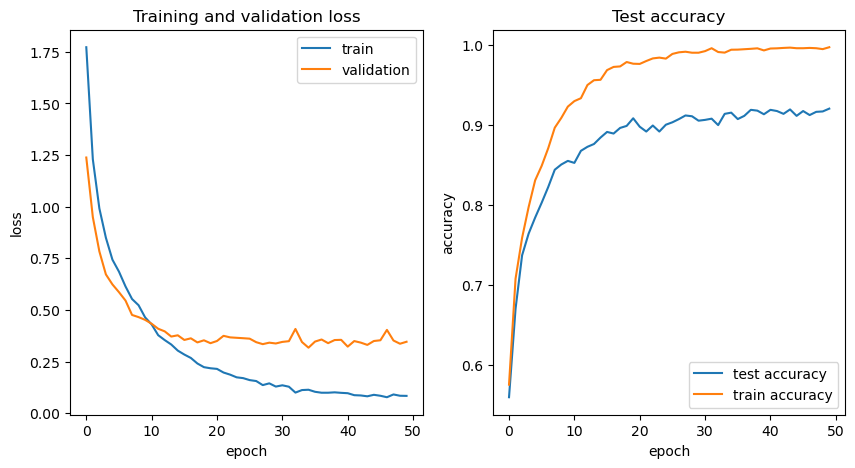

In [9]:
epochs = 50

# Histories
train_history = list()
validation_history = list()
accuracy_test_history = list()
accuracy_train_history = list()

# Training loop
for t in range(epochs):
    print(f"Epoch {t+1}")
    train_loss = train(train_dataloader, model, loss_fn, optimizer, device)
    validation_loss = test_loss(test_dataloader, model, loss_fn, device)


    train_history.append(train_loss)
    validation_history.append(validation_loss)
    accuracy_test_history.append(test_accuracy(test_dataloader, model, device))
    accuracy_train_history.append(test_accuracy(train_dataloader, model, device))
    print("-------------------------------")
    
print("Done!")

print(f"{test_accuracy(test_dataloader, model, device)*100:.2f}%")


# Plots
fig, axs = plt.subplots(1,2, figsize=(10, 5))

# Training and validation loss
axs[0].plot(train_history, label = 'train')
axs[0].plot(validation_history, label = 'validation')
axs[0].set_xlabel("epoch")
axs[0].set_ylabel("loss")
axs[0].set_title("Training and validation loss")
axs[0].legend()

# Accuracy
axs[1].plot(accuracy_test_history, label = 'test accuracy')
axs[1].plot(accuracy_train_history, label = 'train accuracy')
axs[1].set_xlabel("epoch")
axs[1].set_ylabel("accuracy")
axs[1].set_title("Test accuracy")
axs[1].legend()

# Saving the models

This code saves the full model:

In [10]:
torch.save(model, 'models\\model_weights_3_s.pth')

To Load and use the model do:

In [11]:
model = torch.load('models\\model_weights_3_s.pth')
#model.eval()  # Set the model to evaluation mode